## Residual trend analysis

In [1]:
from osgeo import gdal_array
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
import pymannkendall as mk
import rasterio
from rasterio.features import geometry_mask
from rasterio.features import geometry_window
from rasterio.transform import from_origin
import shutil
import pandas as pd
import geopandas as gpd

# Rasters reading

In [2]:
#reading rasters

no_data = 255.0
nb_factors, nb_pixels_height, nb_pixels_width = 2, 126, 229
start_year = 2008
end_year = 2022
nb_years = end_year - start_year + 1
years = np.array([start_year+i for i in range(nb_years)])

factors_str = ["Precipitation", "Soil moisture"]

#load rasters into arrays

#independent variables (X)
# factors[0] : precipitation
# factors[1] : soil moisture
factors = np.ndarray((nb_factors,nb_years,nb_pixels_height,nb_pixels_width))

index_start_year = start_year - 2002
index_end_year = 21 - (2022 - end_year)
#precipitation data
data = gdal_array.LoadFile("/home/eoafrica/shared/driving_factors/aligned_v2/raster-total_precipitation_5km.tif")
factors[0] = data[index_start_year:index_end_year]
#soil moisture data
data = gdal_array.LoadFile("/home/eoafrica/shared/driving_factors/aligned_v2/raster-volumetric_soil_water_layer_1_5km.tif")
factors[1] = data[index_start_year:index_end_year]

#dependent variables (Y)
#vegetation index
vegetation_index = np.ndarray((nb_years,nb_pixels_height,nb_pixels_width))
for i,y in enumerate(years):
    vegetation_index[i] = gdal_array.LoadFile(f"/home/eoafrica/shared/vegetation-maps/5km-resolution/cont/vegetation_cont_5km_{y}.tif")

In [3]:
valid_data_mask = (vegetation_index[0] != no_data)
valid_data_mask_tiled = (vegetation_index != no_data)

In [4]:
#number of valid pixels (different than no_data)
steppe_area = np.count_nonzero(valid_data_mask)*25
print(f"Number of valid pixels: {np.count_nonzero(valid_data_mask)} ({steppe_area} km2)")

Number of valid pixels: 13742 (343550 km2)


# Standardization

In [5]:
def strandardize(arr):
    # Extract valid data values
    valid_data = arr[valid_data_mask_tiled]
    # Calculate mean and standard deviation of valid data
    mean_value = np.mean(valid_data)
    std_dev_value = np.std(valid_data)
    # Standardize valid data
    standardized_data = (valid_data - mean_value) / std_dev_value
    # Replace standardized values in the original data
    arr[valid_data_mask_tiled] = standardized_data
    return arr

In [6]:
# for f in range(nb_factors):
#      factors[f]= strandardize(factors[f])
# vegetation_index = strandardize(vegetation_index)

# Normalization

In [7]:
def normalize(arr):
    # Extract valid data values
    valid_data = arr[valid_data_mask_tiled]   
    # Calculate the minimum and maximum values    
    min_value = np.min(valid_data)
    max_value = np.max(valid_data)
    # Normalize the array
    normalized_array = (valid_data - min_value) / (max_value - min_value)
    # Replace normalized values in the original data
    arr[valid_data_mask_tiled] = normalized_array
    return arr

In [8]:
for f in range(nb_factors):
    factors[f]= normalize(factors[f])
vegetation_index = normalize(vegetation_index)

# Calculations

The used LinearRegression method minimizes the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.
For each pixel and each factor:
* Perform a linear regression of the vegetation index against the factor.
* Get the residues of the linear regression.
* Perform a linear regression of the residues against time. A pixel with a nagative slope could be considered as degraded since the residues are evolving badly (more and more inferior than the linear regression prediction).
* Mark the pixel if it has a significant negative trend of 95%: it has a negative trend (slope) and its slope pvalue is under 0.05.

In [9]:
slopes = np.full((nb_factors,nb_pixels_height,nb_pixels_width),no_data)
intercepts = np.full((nb_factors,nb_pixels_height,nb_pixels_width),no_data)
residuals = np.full((nb_factors,nb_years,nb_pixels_height,nb_pixels_width),no_data)
slopes_residuals = np.full((nb_factors,nb_pixels_height,nb_pixels_width),no_data)
negative = np.full((nb_factors,nb_pixels_height,nb_pixels_width),no_data)
significant = np.full((nb_factors,nb_pixels_height,nb_pixels_width),no_data)
significant_pos = np.full((nb_factors,nb_pixels_height,nb_pixels_width),no_data)
rsquared = np.full((nb_factors,nb_pixels_height,nb_pixels_width),no_data)

alpha = 0.05

for i in range(nb_pixels_height):
    for j in range(nb_pixels_width):
        if (valid_data_mask[i,j]):
            for f in range(nb_factors):
                #linear regression of vegetation index against factor[f]
                FACTOR = sm.add_constant(factors[f,:,i,j])
                model = sm.OLS(vegetation_index[:,i,j], FACTOR).fit()
                slopes[f,i,j] = model.params[1]
                intercepts[f,i,j] = model.params[0]
                residuals[f,:,i,j] = model.resid                
                rsquared[f,i,j] = model.rsquared
                
                #Linear regression of residuals against years
                YEARS = sm.add_constant(years)
                model_residuals = sm.OLS(residuals[f,:,i,j], YEARS).fit()
                slopes_residuals[f,i,j] = model_residuals.params[1]
                p_value = model_residuals.pvalues[1]
                #A pixel has a negative trend if it has a negative slope (residuals against time)
                negative[f,i,j] = (1.0 if slopes_residuals[f,i,j]<0 else 0.0)
                #A pixel signficance is checked only if it has a negative slope (residuals against time)
                significant[f,i,j] = 1.0 if ((slopes_residuals[f,i,j]<0) and (p_value <= alpha)) else 0.0
                significant_pos[f,i,j] = 1.0 if ((slopes_residuals[f,i,j]>0) and (p_value <= alpha)) else 0.0

# Linear regression slopes and intercepts for the actual vegetation index against the factors

## Precipitation

##### For the pixel [0,125]

0.0720287210225179 0.6681095424866563


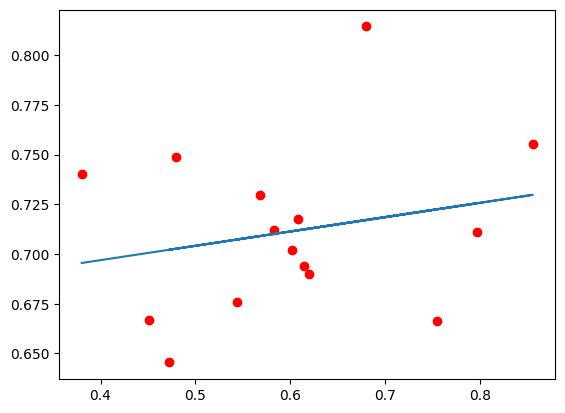

In [10]:
plt.scatter(factors[0,:,0,125], vegetation_index[:,0,125], color="red")
Factor = sm.add_constant(factors[0,:,0,125])
results = sm.OLS(vegetation_index[:,0,125], Factor).fit()
slope = results.params[1]
intercept = results.params[0]
print(slope,intercept)
plt.plot(factors[0,:,0,125], slope*factors[0,:,0,125]+intercept)

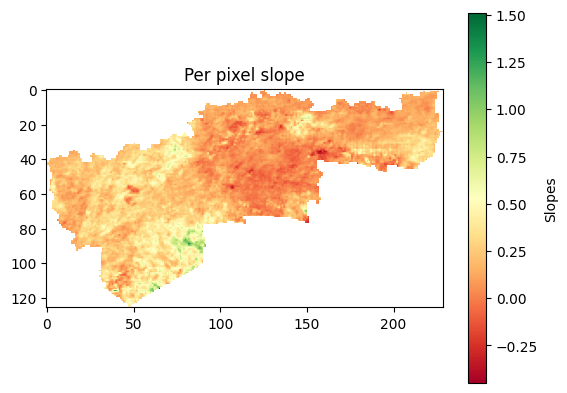

In [11]:
masked_slopes = np.ma.masked_where(slopes[0] == no_data, slopes[0]) 
plt.imshow(masked_slopes, cmap="RdYlGn",vmin=masked_slopes.min(), vmax=masked_slopes.max()) 
plt.colorbar(label='Slopes') 
plt.title('Per pixel slope') 
plt.show() 

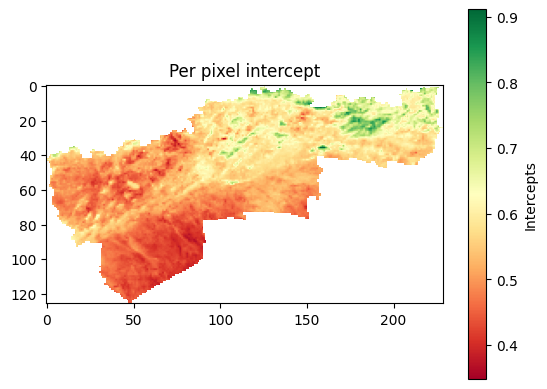

In [12]:
masked_intercepts = np.ma.masked_where(intercepts[0] == no_data, intercepts[0]) 
plt.imshow(masked_intercepts, cmap="RdYlGn", vmin=masked_intercepts.min(), vmax=masked_intercepts.max()) 
plt.colorbar(label='Intercepts') 
plt.title('Per pixel intercept') 
plt.show() 

## Soil moisture

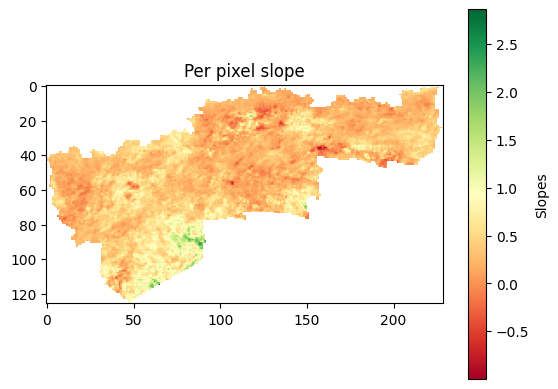

In [13]:
masked_slopes = np.ma.masked_where(slopes[1] == no_data, slopes[1]) 
plt.imshow(masked_slopes, cmap="RdYlGn", vmin=masked_slopes.min(), vmax=masked_slopes.max()) 
plt.colorbar(label='Slopes') 
plt.title('Per pixel slope') 
plt.show() 

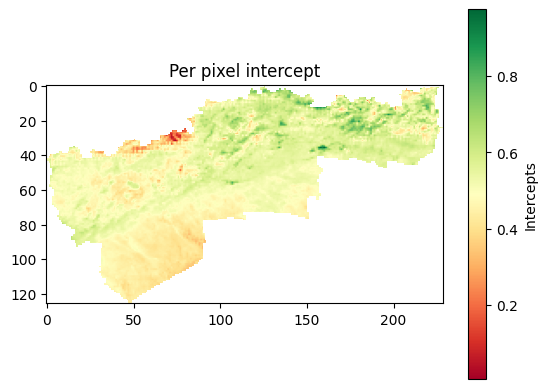

In [14]:
masked_intercepts = np.ma.masked_where(intercepts[1] == no_data, intercepts[1]) 
plt.imshow(masked_intercepts, cmap="RdYlGn", vmin=masked_intercepts.min(), vmax=masked_intercepts.max()) 
plt.colorbar(label='Intercepts') 
plt.title('Per pixel intercept') 
plt.show() 

# Correlation

In [15]:
for f in range(nb_factors):  
    mask = rsquared[f,:,:] > 2
    # Create a masked array
    masked_data = np.ma.masked_array(rsquared[f,:,:], mask)
    # Calculate the average while ignoring masked values
    average_rquared = np.ma.mean(masked_data)
    std_rquared = np.ma.std(masked_data)
    print(f"Average R² for {factors_str[f]} : {average_rquared:.4f}")
    print(f"Std. dev. R² for {factors_str[f]} : {std_rquared:.4f}")
    print('-------------------------------')

Average R² for Precipitation : 0.1272
Std. dev. R² for Precipitation : 0.1191
-------------------------------
Average R² for Soil moisture : 0.1233
Std. dev. R² for Soil moisture : 0.1085
-------------------------------


# Residual differences

In [16]:
masked_slopes_residuals = np.ma.masked_where(slopes_residuals == no_data, slopes_residuals) 
masked_negative = np.ma.masked_where(negative == no_data, negative)
masked_significant = np.ma.masked_where(significant == no_data, significant) 

In [17]:
labels_negative = ["Not negative", "Negative"]
labels_significant = ["Not negative significant", "Negative significant"]

In [18]:
def patch(arr,labels):
    values = np.unique(arr[valid_data_mask])
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = []
    for i in values:
        i = int(i)
        patches.append(mpatches.Patch(color=colors[i], label=labels[i]))
    return patches

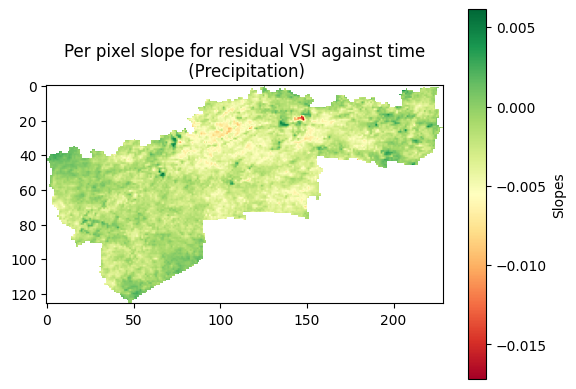

In [19]:
plt.imshow(masked_slopes_residuals[0], cmap="RdYlGn", vmin=masked_slopes_residuals.min(), vmax=masked_slopes_residuals.max()) 
plt.colorbar(label='Slopes') 
plt.title(f'Per pixel slope for residual VSI against time\n ({factors_str[0]})')
plt.show()

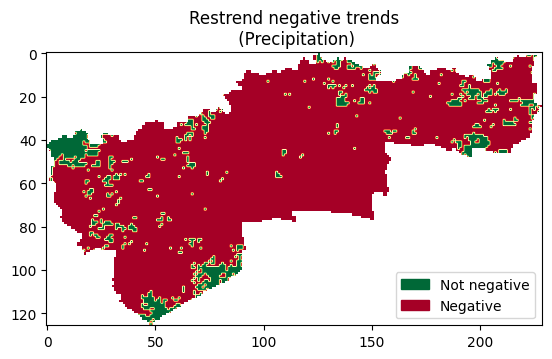

Number of negative trend pixel: {0: 1388, 1: 12354, 255: 15112}


In [20]:
im = plt.imshow(masked_negative[0], cmap="RdYlGn_r")
plt.legend(handles=patch(negative[0],labels_negative), loc='lower right' )
plt.title(f'Restrend negative trends\n ({factors_str[0]})')
plt.show()
unique, counts = np.unique(negative[0], return_counts=True)
print(f"Number of negative trend pixel: {dict(zip(unique.astype(int), counts))}")

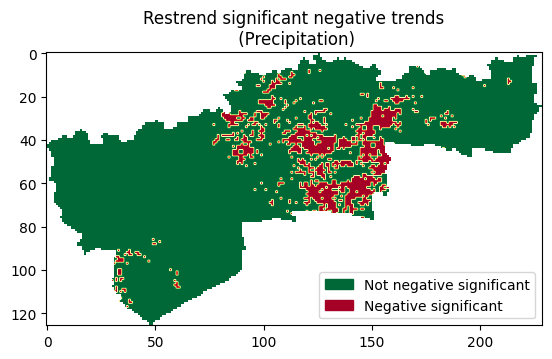

Repartition of pixels: {0: 12256, 1: 1486, 255: 15112}
Total area with significative negative trend: 37150 km2 (10.81% of the steppe)


In [21]:
plt.imshow(masked_significant[0], cmap="RdYlGn_r")
plt.legend(handles=patch(significant[0],labels_significant), loc='lower right' )
plt.title(f'Restrend significant negative trends\n ({factors_str[0]})')
plt.show()
unique, counts = np.unique(significant[0], return_counts=True)
results = dict(zip(unique.astype(int), counts))
print(f"Repartition of pixels: {results}")
print(f"Total area with significative negative trend: {results[1]*25} km2 ({results[1]*2500/steppe_area:.2f}% of the steppe)")

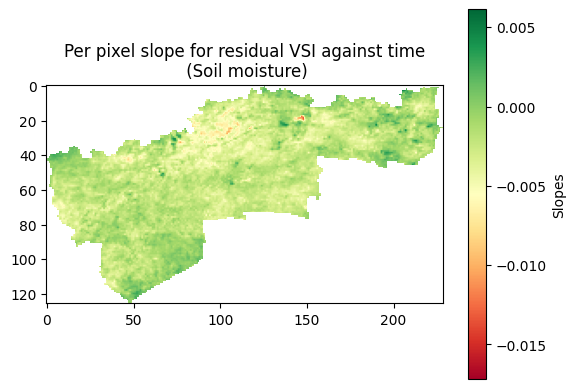

In [22]:
plt.imshow(masked_slopes_residuals[1], cmap="RdYlGn", vmin=masked_slopes_residuals.min(), vmax=masked_slopes_residuals.max()) 
plt.colorbar(label='Slopes') 
plt.title(f'Per pixel slope for residual VSI against time\n ({factors_str[1]})')
plt.show()

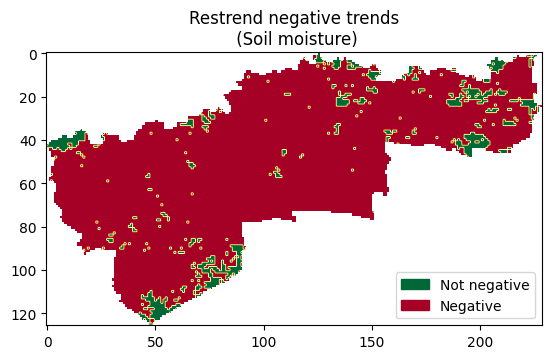

In [23]:
im = plt.imshow(masked_negative[1], cmap="RdYlGn_r")
plt.legend(handles=patch(negative[1],labels_negative), loc='lower right' )
plt.title(f'Restrend negative trends\n ({factors_str[1]})')
plt.show()

Repartition of pixels: {0: 13370, 1: 372, 255: 15112}
Total area with significative negative trend: 9300 km² (2.71% of the steppe)


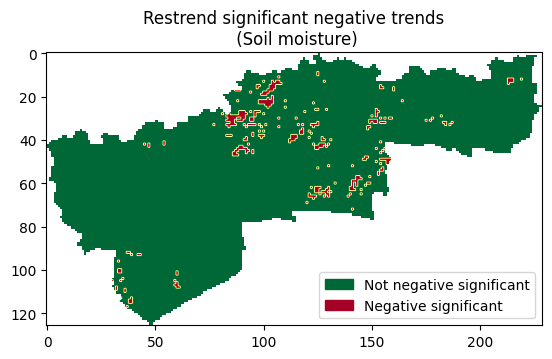

In [42]:

im = plt.imshow(masked_significant[1], cmap="RdYlGn_r")
plt.legend(handles=patch(significant[1],labels_significant), loc='lower right' )
plt.title(f'Restrend significant negative trends\n ({factors_str[1]})')
# plt.show()
plt.savefig("tt.png")
unique, counts = np.unique(significant[1], return_counts=True)
results = dict(zip(unique.astype(int), counts))
print(f"Repartition of pixels: {results}")
print(f"Total area with significative negative trend: {results[1]*25} km² ({results[1]*2500/steppe_area:.2f}% of the steppe)")

In [41]:
plt.savefig("pp.png")

<Figure size 640x480 with 0 Axes>

# Average residual per year

In [26]:
avg_residue = np.ndarray((nb_factors,nb_years))
for f in range(nb_factors):
    for y in range(nb_years):
        avg_residue[f,y] = np.average(residuals[f,y][valid_data_mask])    

## Precipitation

In [27]:
avg_residue[0]

array([ 0.01398878,  0.01269989,  0.07586495, -0.03179732,  0.01157945,
       -0.02346392,  0.00581087, -0.01287118,  0.01952208, -0.0337863 ,
        0.00284464, -0.0300163 ,  0.01240136, -0.0392206 ,  0.01644361])

<BarContainer object of 15 artists>

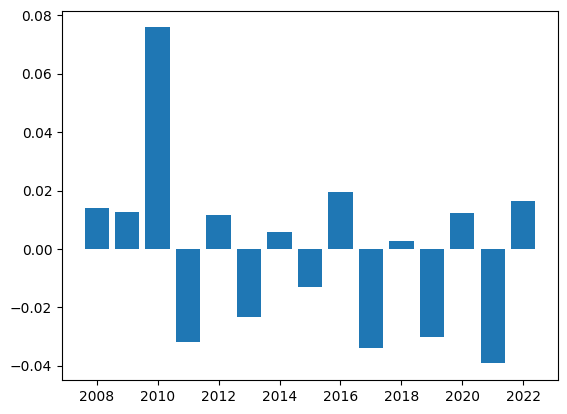

In [28]:
plt.bar(years, avg_residue[0])

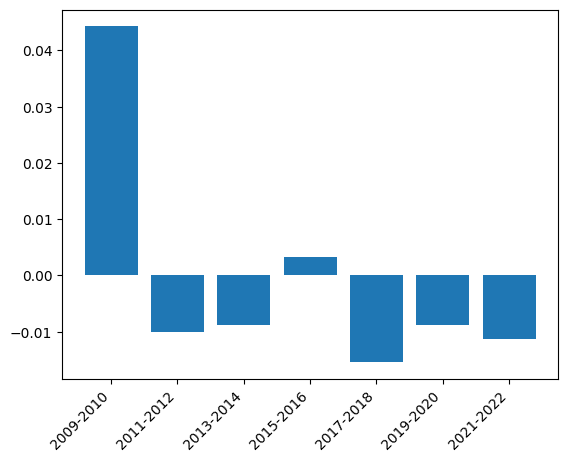

In [29]:
avgr = avg_residue[0][1:]
averaged_array = np.average(avgr.reshape(-1, 2), axis=1)

# Create a bar plot
plt.bar(range(len(averaged_array)), averaged_array)

# Customize the x-axis ticks and labels
custom_ticks = np.arange(len(averaged_array))  # Set custom tick positions
custom_labels = [f"{years[i]}-{years[i+1]}" for i in range(1, len(avgr), 2)]  # Set custom tick labels

plt.xticks(custom_ticks, custom_labels,rotation=45, ha="right")
plt.show()

## Soil moisture

In [30]:
avg_residue[1]

array([ 0.01086862,  0.00889709,  0.08016648, -0.02720658,  0.00960819,
       -0.02437755,  0.00331071, -0.01573059,  0.0207631 , -0.03724463,
        0.00871102, -0.02930333,  0.01413936, -0.03769857,  0.01509669])

<BarContainer object of 15 artists>

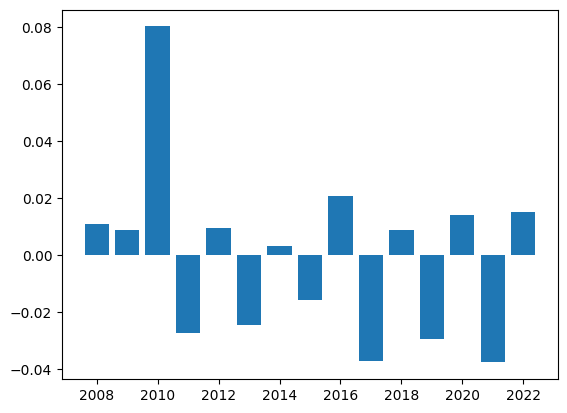

In [31]:
plt.bar(years, avg_residue[1])

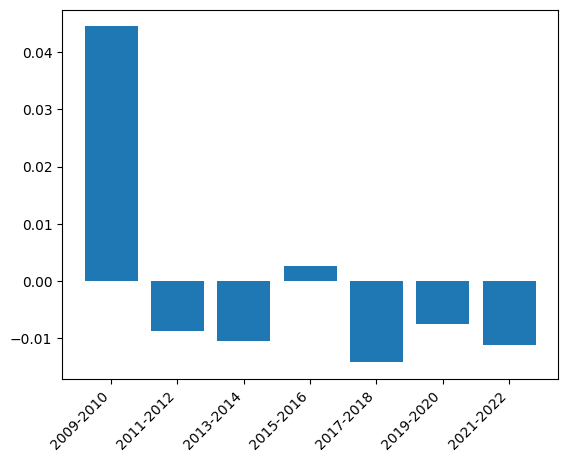

In [32]:
avgr = avg_residue[1][1:]
averaged_array = np.average(avgr.reshape(-1, 2), axis=1)

# Create a bar plot
plt.bar(range(len(averaged_array)), averaged_array)

# Customize the x-axis ticks and labels
custom_ticks = np.arange(len(averaged_array))  # Set custom tick positions
custom_labels = [f"{years[i]}-{years[i+1]}" for i in range(1, len(avgr), 2)]  # Set custom tick labels

plt.xticks(custom_ticks, custom_labels,rotation=45, ha="right")
plt.show()

# Raster export

Export numpy array to a raster by coping an existing one and updating it (to keep metadata).

In [33]:
def duplicate_file(source_path, destination_path):
    try:
        # Copy the file from source_path to destination_path
        shutil.copy2(source_path, destination_path)
    except Exception as e:
        print(f"Error duplicating file: {e}")

In [34]:
def export_raster(path,new_path,arr):
    duplicate_file(path,new_path)
    # Open the raster file in read-write mode
    with rasterio.open(new_path, 'r+') as src:
        # Read the raster data as a NumPy array
        data = src.read(1)

        # Replace the old content
        data = arr

        # Write the modified array back to the raster
        src.write(data, 1)

In [35]:
#Export slopes[1] array to the file "new.tiff".
export_raster("original.tiff","neg_trends_"+str(start_year)+"_"+str(end_year)+".tiff",significant[0])
export_raster("original.tiff","pos_trends_"+str(start_year)+"_"+str(end_year)+".tiff",significant_pos[0])

In [36]:
def count_pixels(tiff_path, shapefile_path, attribute_field, target_pixel_value):
    # Step 1: Read TIFF file
    with rasterio.open(tiff_path) as src:
        raster_profile = src.profile
        raster_data = src.read(1)  # Assuming a single-band raster
        
    transform = src.transform
    out_shape = raster_data.shape    

    # Step 2: Read Shapefile and select features based on attribute
    gdf = gpd.read_file(shapefile_path)
    gdf = gdf.to_crs(epsg=4326)
    # Step 3: Count pixels with the specified value in selected features
    wilayas = []
    pixels_count = []
    areas = []
    degraded_area = []
    degradation_per = []
    total_area = 0

    for index, feature in gdf.iterrows():
        # Use the original feature geometry as the mask
        mask = geometry_mask([feature.geometry], out_shape=out_shape, transform=src.transform, invert=True)
        # Count pixels with the specified value inside the feature geometry
        count = (raster_data[mask] == target_pixel_value).sum()
        # The Wilaya area is obtained by counting pixels from raster_data[mask] with data
        area = (raster_data[mask] != no_data).sum()
    
        if count != 0 :                 
            total_area += area
            wilayas.append(feature['ADM1_EN'])
            pixels_count.append(count)
            areas.append(area*25)
            degraded_area.append(count*25) 
            degradation_per.append(count*100/(area))
        
    results = pd.DataFrame({"wilaya":wilayas,
                            "count":pixels_count,
                            "area":areas,
                            "degraded area":degraded_area, 
                            "degradation":degradation_per})
    return results

#### Remarks:
* 80 pixels at the border of the steppic region are not taken into account since their center does not belong steppic map shape file (2000km²).
* For every Wilaya, only the area belonging to the steppic region is given. The degradation percentage is calculated accordigly.

In [37]:
tiff_file_path = "./neg_trends_"+str(start_year)+"_"+str(end_year)+".tiff"
shapefile_path = "/home/eoafrica/shared/Datasets/shapefiles_algeria/dza_admbnda_unhcr2020_shp/dza_admbnda_adm1_unhcr_20200120.shp"
attribute_name = "ADM1_EN"
target_pixel_val = 1 
results = count_pixels(tiff_file_path, shapefile_path, attribute_name, target_pixel_val).sort_values('degradation', ascending =False)
results

,wilaya,count,area,degraded area,degradation
5,Djelfa,556,39250,13900,35.414013
3,Biskra,348,26075,8700,33.365292
7,El Oued,16,1425,400,28.070175
0,Ain-Defla,1,100,25,25.000000
10,Laghouat,195,33150,4875,14.705882
1,Batna,78,15075,1950,12.935323
8,Ghardaia,8,1550,200,12.903226
11,M'Sila,107,21900,2675,12.214612
2,Bechar,6,1300,150,11.538462
17,Tiaret,72,16200,1800,11.111111
